# PFB filter weights investigation

MeerKAT's PFB filter weights are slightly odd because they multiply a sinc and a Hann window that are slightly offset from each other (by half a sample). More details are in NGC-278. This notebook looks at what effect this has on the frequency-domain response.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def generate_weights(channels: int, taps: int, bias: float = 0.5) -> np.ndarray:
    """Generate Hann-window weights for the F-engine's PFB-FIR.

    Parameters
    ----------
    channels
        Number of channels in the PFB.
    taps
        Number of taps in the PFB-FIR.
    bias
        Shift in the sinc (0.5 produces a symmetric output, 0 produces MeerKAT output)

    Returns
    -------
    :class:`numpy.ndarray`
        Array containing the weights for the PFB-FIR filters, as
        single-precision floats.
    """
    step = 2 * channels
    window_size = step * taps
    idx = np.arange(window_size)
    hann = np.square(np.sin(np.pi * (idx / (window_size - 1))))
    sinc = np.sinc((idx + bias) / step - taps / 2)
    return hann * sinc

In [3]:
def angles(data: np.ndarray) -> np.ndarray:
    """Compute angles of complex numbers, modulo pi.
    
    Working modulo pi ensures that a purely real function has a consistent
    angle of zero, rather than bouncing between 0 and pi.
    """
    angles = (np.angle(data) + np.pi/2) % np.pi - np.pi/2
    return angles

Set up the number of channels and filter taps. As these get larger the effects get smaller, so small values are used to make the effects more visible.

In [4]:
channels = 64
taps = 8

Generate the two versions of the filter.

<IPython.core.display.Javascript object>


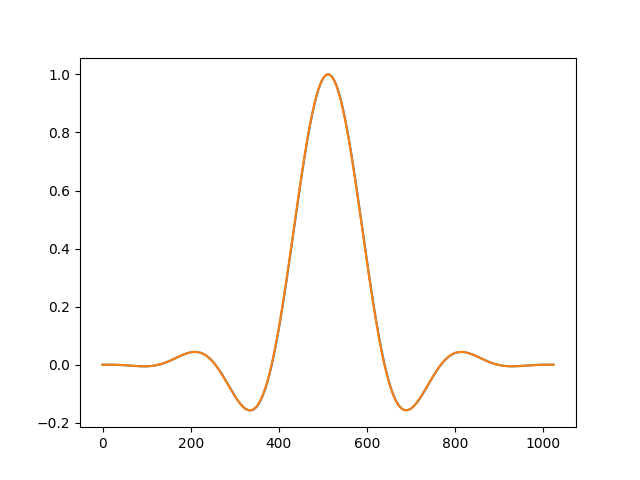

In [5]:
y = generate_weights(channels, taps, bias=0)    # MeerKAT output
z = generate_weights(channels, taps, bias=0.5)  # symmetric output
plt.figure()
plt.plot(y)
plt.plot(z);

To better approximate the continuous Fourier transform, we'll pad the signal with zeros. The output is shifted so that the middle represents the response to a signal at the channel centre.

In [6]:
pad = np.zeros(10000)
Y = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.r_[pad, y, pad])))
Z = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.r_[pad, z, pad])))
x = np.arange(len(Y)) * channels / len(Y)

## Phase

Note that the patterns are largely sampling artefacts, and change radically depending on the amount of padding used in the FFT.

<IPython.core.display.Javascript object>


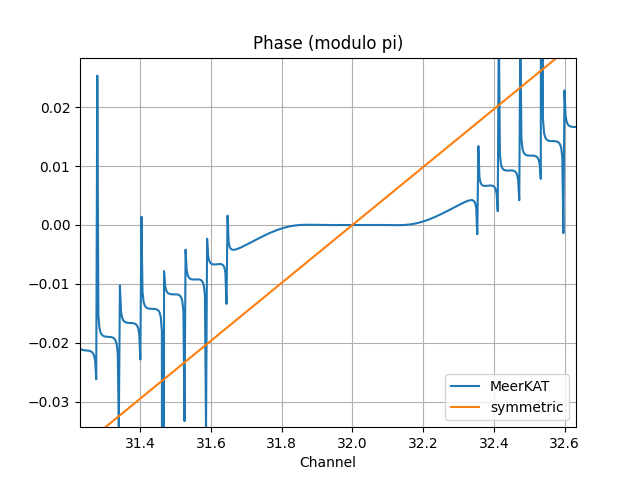

In [7]:
plt.figure()
plt.plot(x, angles(Y), label="MeerKAT")
plt.plot(x, angles(Z), label="symmetric")
plt.title("Phase (modulo pi)")
plt.xlabel("Channel")
plt.grid()
plt.legend();

## Magnitude

Magnitudes are almost indistinguishable. The difference plot shows that the symmetric filter has fractionally higher power in the main lobe and very fractionally less power in the sidelobes.

<IPython.core.display.Javascript object>


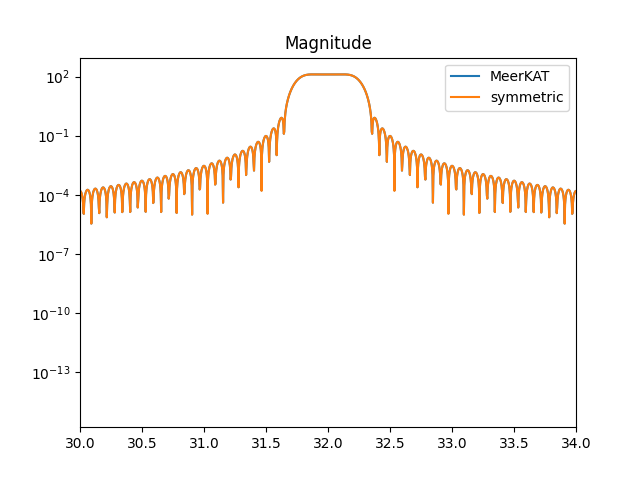

In [14]:
plt.figure()
plt.semilogy(x, np.abs(Y), label="MeerKAT")
plt.semilogy(x, np.abs(Z), label="symmetric")
plt.xlim(channels / 2 - 2, channels / 2 + 2)
plt.title("Magnitude")
plt.legend();

<IPython.core.display.Javascript object>


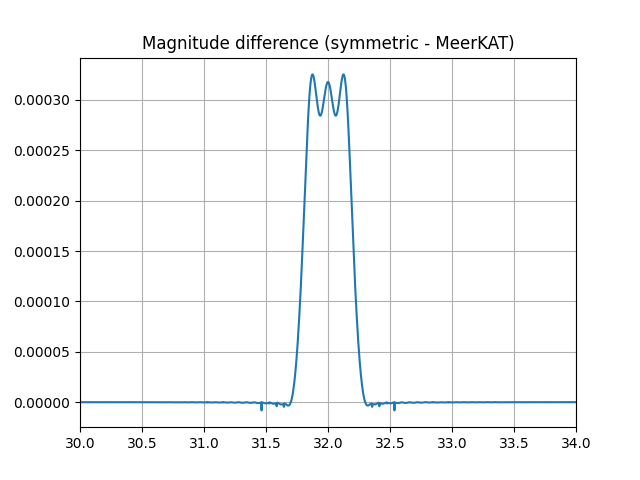

In [13]:
plt.figure()
plt.plot(x, np.abs(Z) - np.abs(Y))
plt.title("Magnitude difference (symmetric - MeerKAT)")
plt.xlim(channels / 2 - 2, channels / 2 + 2)
plt.grid();